
# Calculating power loss from partial module shading

Example of modeling cell-to-cell mismatch loss from partial module shading.


Even though the PV cell is the primary power generation unit, PV modeling is
often done at the module level for simplicity because module-level parameters
are much more available and it significantly reduces the computational scope
of the simulation.  However, module-level simulations are too coarse to be
able to model effects like cell to cell mismatch or partial shading.  This
example calculates cell-level IV curves and combines them to reconstruct
the module-level IV curve.  It uses this approach to find the maximum power
under various shading and irradiance conditions.

The primary functions used here are:

- :py:meth:`pvlib.pvsystem.calcparams_desoto` to estimate the single
  diode equation parameters at some specified operating conditions.
- :py:meth:`pvlib.singlediode.bishop88` to calculate the full cell IV curve,
  including the reverse bias region.

<div class="alert alert-info"><h4>Note</h4><p>This example requires the reverse bias functionality added in pvlib 0.7.2</p></div>

<div class="alert alert-danger"><h4>Warning</h4><p>Modeling partial module shading is complicated and depends significantly
    on the module's electrical topology.  This example makes some simplifying
    assumptions that are not generally applicable.  For instance, it assumes
    that shading only applies to beam irradiance (*i.e.* all cells receive
    the same amount of diffuse irradiance) and cell temperature is uniform
    and not affected by cell-level irradiance variation.</p></div>



In [11]:
from pvlib import pvsystem, singlediode
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import warnings

from scipy.constants import e as qe, k as kB

# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

cell_parameters = {
    'I_L_ref': 8.24,
    'I_o_ref': 2.36e-9,
    'a_ref': 1.3*Vth,
    'R_sh_ref': 1000,
    'R_s': 0.00181,
    'alpha_sc': 0.0042,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

## Simulating a cell IV curve

First, calculate IV curves for individual cells.  The process is as follows:

1) Given a set of cell parameters at reference conditions and the operating
   conditions of interest (irradiance and temperature), use a single-diode
   model to calculate the single diode equation parameters for the cell at
   the operating conditions.  Here we use the De Soto model via
   :py:func:`pvlib.pvsystem.calcparams_desoto`.
2) The single diode equation cannot be solved analytically, so pvlib has
   implemented a couple methods of solving it for us.  However, currently
   only the Bishop '88 method (:py:func:`pvlib.singlediode.bishop88`) has
   the ability to model the reverse bias characteristic in addition to the
   forward characteristic.  Depending on the nature of the shadow, it is
   sometimes necessary to model the reverse bias portion of the IV curve,
   so we use the Bishop '88 method here.  This gives us a set of (V, I)
   points on the cell's IV curve.



In [12]:
def simulate_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    sde_args = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        'breakdown_factor': parameters['breakdown_factor'],
        'breakdown_exp': parameters['breakdown_exp'],
        'breakdown_voltage': parameters['breakdown_voltage'],
    }
    v_oc = singlediode.bishop88_v_from_i(
        0.0, *sde_args, **kwargs
    )
    # ideally would use some intelligent log-spacing to concentrate points
    # around the forward- and reverse-bias knees, but this is good enough:
    vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

    ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
    return pd.DataFrame({
        'i': ivcurve_i,
        'v': ivcurve_v,
    })

Now that we can calculate cell-level IV curves, let's compare a
fully-illuminated cell's curve to a shaded cell's curve.  Note that shading
typically does not reduce a cell's illumination to zero -- tree shading and
row-to-row shading block the beam portion of irradiance but leave the diffuse
portion largely intact.  In this example plot, we choose $200 W/m^2$
as the amount of irradiance received by a shaded cell.



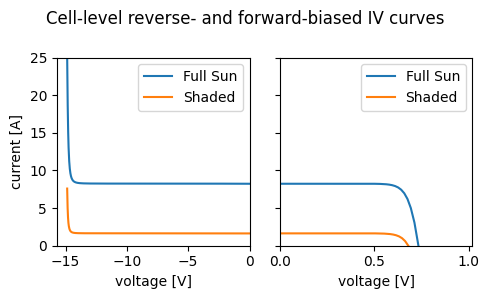

In [13]:
def plot_curves(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes


cell_curve_full_sun = simulate_full_curve(cell_parameters, Geff=1000, Tcell=25)
cell_curve_shaded = simulate_full_curve(cell_parameters, Geff=200, Tcell=25)
ax = plot_curves([cell_curve_full_sun, cell_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Cell-level reverse- and forward-biased IV curves')

This figure shows how a cell's current decreases roughly in proportion to
the irradiance reduction from shading, but voltage changes much less.
At the cell level, the effect of shading is essentially to shift the I-V
curve down to lower currents rather than change the curve's shape.

Note that the forward and reverse curves are plotted separately to
accommodate the different voltage scales involved -- a normal crystalline
silicon cell reaches only ~0.6V in forward bias, but can get to -10 to -20V
in reverse bias.

## Combining cell IV curves to create a module IV curve

To combine the individual cell IV curves and form a module's IV curve,
the cells in each substring must be added in series.  The substrings are
in series as well, but with parallel bypass diodes to protect from reverse
bias voltages.  To add in series, the voltages for a given current are
added.  However, because each cell's curve is discretized and the currents
might not line up, we align each curve to a common set of current values
with interpolation.



In [14]:
def interpolate(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)


def combine_series(dfs):
    """
    Combine IV curves in series by aligning currents and summing voltages.
    The current range is based on the first curve's current range.
    """
    df1 = dfs[0]
    imin = df1['i'].min()
    imax = df1['i'].max()
    i = np.linspace(imin, imax, 1000)
    v = 0
    for df2 in dfs:
        v_cell = interpolate(df2, i)
        v += v_cell
    return pd.DataFrame({'i': i, 'v': v})

Rather than simulate all 72 cells in the module, we'll assume that there
are only three types of cells (fully illuminated, fully shaded, and
partially shaded), and within each type all cells behave identically.  This
means that simulating one cell from each type (for three cell simulations
total) is sufficient to model the module as a whole.

This function also models the effect of bypass diodes in parallel with each
substring.  Bypass diodes are normally inactive but conduct when substring
voltage becomes sufficiently negative, presumably due to the substring
entering reverse bias from mismatch between substrings.  In that case the
substring's voltage is clamped to the diode's trigger voltage (assumed to
be 0.5V here).



In [15]:
def simulate_module(cell_parameters, poa_direct, poa_diffuse, Tcell,
                    shaded_fraction, cells_per_string=24, strings=3):
    """
    Simulate the IV curve for a partially shaded module.
    The shade is assumed to be coming up from the bottom of the module when in
    portrait orientation, so it affects all substrings equally.
    For simplicity, cell temperature is assumed to be uniform across the
    module, regardless of variation in cell-level illumination.
    Substrings are assumed to be "down and back", so the number of cells per
    string is divided between two columns of cells.
    """
    # find the number of cells per column that are in full shadow
    nrow = cells_per_string // 2
    nrow_full_shade = int(shaded_fraction * nrow)
    # find the fraction of shade in the border row
    partial_shade_fraction = 1 - (shaded_fraction * nrow - nrow_full_shade)

    df_lit = simulate_full_curve(
        cell_parameters,
        poa_diffuse + poa_direct,
        Tcell)
    df_partial = simulate_full_curve(
        cell_parameters,
        poa_diffuse + partial_shade_fraction * poa_direct,
        Tcell)
    df_shaded = simulate_full_curve(
        cell_parameters,
        poa_diffuse,
        Tcell)
    # build a list of IV curves for a single column of cells (half a substring)
    include_partial_cell = (shaded_fraction < 1)
    half_substring_curves = (
        [df_lit] * (nrow - nrow_full_shade - 1)
        + ([df_partial] if include_partial_cell else [])  # noqa: W503
        + [df_shaded] * nrow_full_shade  # noqa: W503
    )
    substring_curve = combine_series(half_substring_curves)
    substring_curve['v'] *= 2  # turn half strings into whole strings
    # bypass diode:
    substring_curve['v'] = substring_curve['v'].clip(lower=-0.5)
    # no need to interpolate since we're just scaling voltage directly:
    substring_curve['v'] *= strings
    return substring_curve

Now let's see how shade affects the IV curves at the module level.  For this
example, the bottom 10% of the module is shaded.  Assuming 12 cells per
column, that means one row of cells is fully shaded and another row is
partially shaded.  Even though only 10% of the module is shaded, the
maximum power is decreased by roughly 80%!

Note the effect of the bypass diodes.  Without bypass diodes, operating the
shaded module at the same current as the fully illuminated module would
create a reverse-bias voltage of several hundred volts!  However, the diodes
prevent the reverse voltage from exceeding 1.5V (three diodes at 0.5V each).



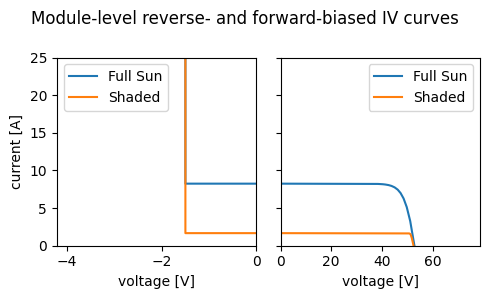

In [16]:
kwargs = {
    'cell_parameters': cell_parameters,
    'poa_direct': 800,
    'poa_diffuse': 200,
    'Tcell': 25
}
module_curve_full_sun = simulate_module(shaded_fraction=0, **kwargs)
module_curve_shaded = simulate_module(shaded_fraction=0.1, **kwargs)
ax = plot_curves([module_curve_full_sun, module_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Module-level reverse- and forward-biased IV curves')

## Calculating shading loss across shading scenarios

Clearly the module-level IV-curve is strongly affected by partial shading.
This heatmap shows the module maximum power under a range of partial shade
conditions, where "diffuse fraction" refers to the ratio
$poa_{diffuse} / poa_{global}$ and "shaded fraction" refers to the
fraction of the module that receives only diffuse irradiance.



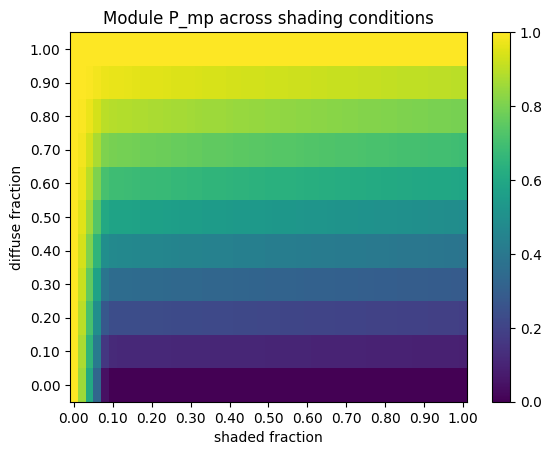

In [17]:
def find_pmp(df):
    """simple function to find Pmp on an IV curve"""
    return df.product(axis=1).max()


# find Pmp under different shading conditions
data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # Your code that generates warnings
    for diffuse_fraction in np.linspace(0, 1, 11):
        for shaded_fraction in np.linspace(0, 1, 51):

            df = simulate_module(cell_parameters,
                                poa_direct=(1-diffuse_fraction)*1000,
                                poa_diffuse=diffuse_fraction*1000,
                                Tcell=25,
                                shaded_fraction=shaded_fraction)
            data.append({
                'fd': diffuse_fraction,
                'fs': shaded_fraction,
                'pmp': find_pmp(df)
            })

results = pd.DataFrame(data)
results['pmp'] /= results['pmp'].max()  # normalize power to 0-1
results_pivot = results.pivot(index='fd', columns='fs', values='pmp')
#results_pivot = results.pivot('fd', 'fs', 'pmp')
plt.figure()
plt.imshow(results_pivot, origin='lower', aspect='auto')
plt.xlabel('shaded fraction')
plt.ylabel('diffuse fraction')
xlabels = [f"{fs:0.02f}" for fs in results_pivot.columns[::5]]
ylabels = [f"{fd:0.02f}" for fd in results_pivot.index]
plt.xticks(range(0, 5*len(xlabels), 5), xlabels)
plt.yticks(range(0, len(ylabels)), ylabels)
plt.title('Module P_mp across shading conditions')
plt.colorbar()
plt.show()
# use this figure as the thumbnail:
# sphinx_gallery_thumbnail_number = 3

The heatmap makes a few things evident:

- When diffuse fraction is equal to 1, there is no beam irradiance to lose,
  so shading has no effect on production.
- When shaded fraction is equal to 0, no irradiance is blocked, so module
  output does not change with the diffuse fraction.
- Under sunny conditions (diffuse fraction < 0.5), module output is
  significantly reduced after just the first cell is shaded
  (1/12 = ~8% shaded fraction).

